# No Split Experiment Results

**Last Modified**: Nov 22, 2024

In this notebook, we summarize and visualize the results from `no_split` experiment. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System & OS

import sys
import os
import time
import warnings
import random
import psutil
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                            get_figures_dir,
                            get_matched_data_path,
                            get_matched_metadata_path)

from src.utils.plot import(multi_label_predictions)

from src.utils.data import (setup_data_objects,
                            setup_multilabel_dataloaders,
                            get_exp_filter_profiles)

from src.utils.conformal import validate

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             SAMPLING_RATE,
                             id_mapping)

from src.data_prep.data_prep_utils import combined_annotations

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams['legend.fontsize'] = 40
mpl.rcParams['axes.titlesize'] = 45
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

In [4]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)
experiment_name = 'no_split'

#### Hyperparameter Tuning

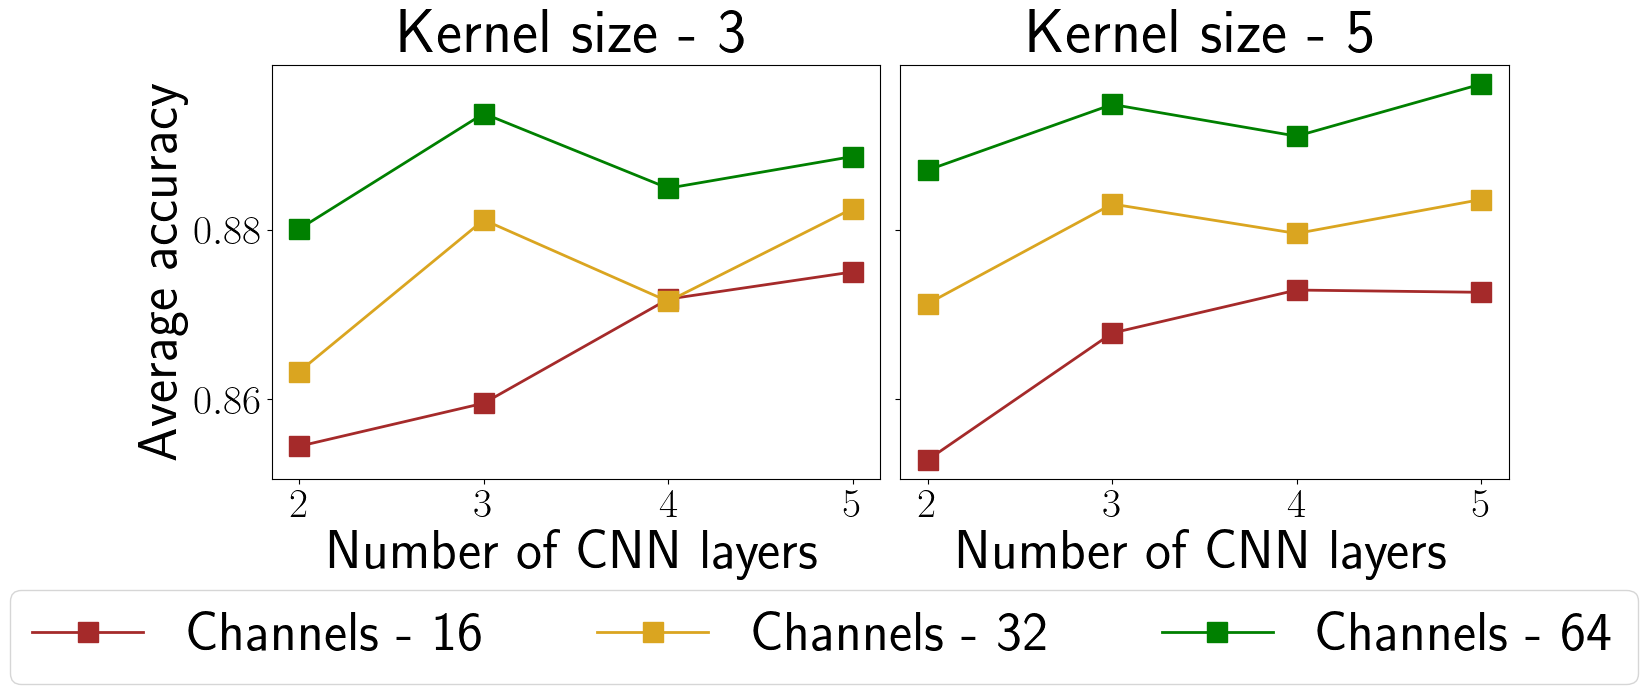

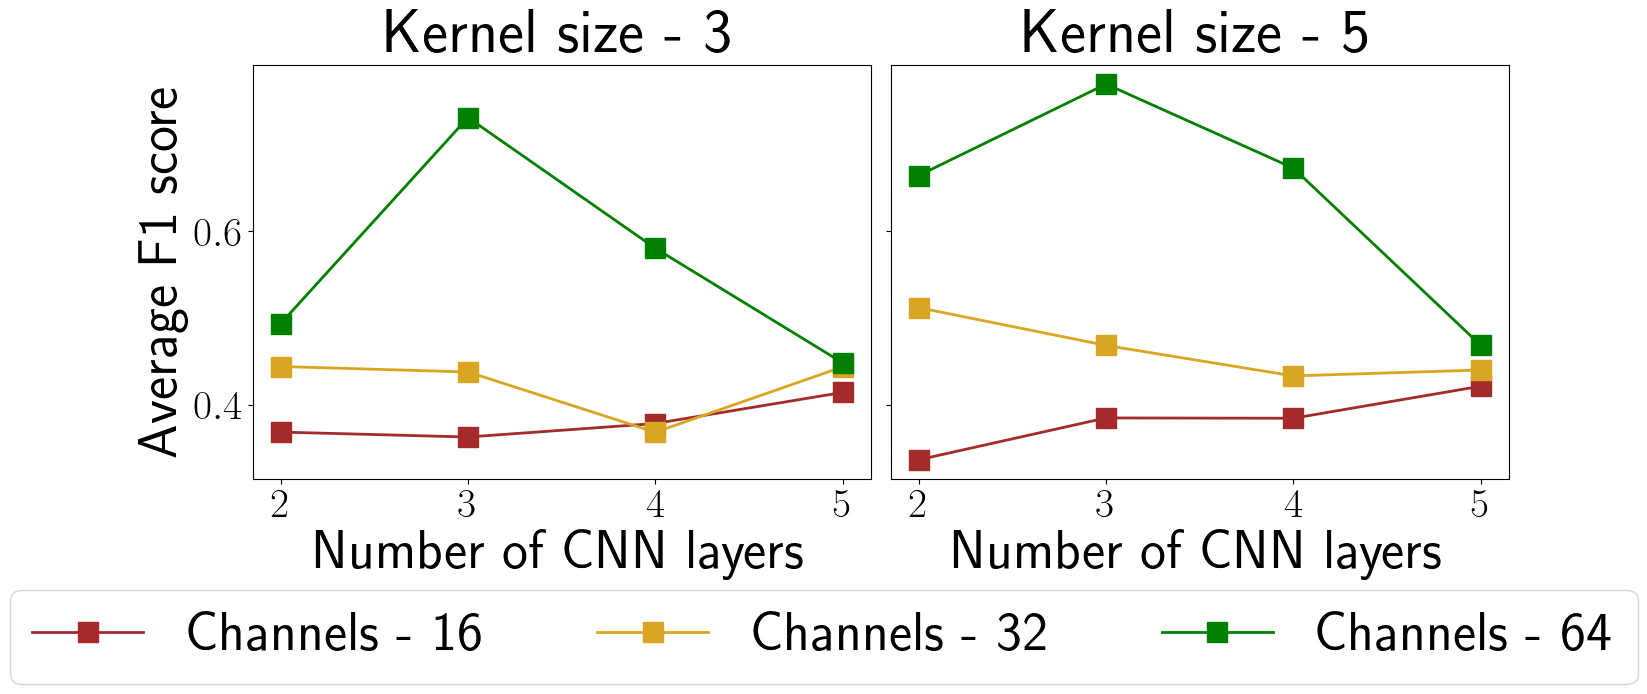

In [5]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

channels, layers, kernel_sizes = [16, 32, 64], [2, 3, 4, 5], [3, 5]
accuracies = np.zeros((len(channels), len(layers), len(kernel_sizes)))
f1_scores = np.zeros((len(channels), len(layers), len(kernel_sizes)))
colors = ['brown', 'goldenrod', 'green']


for i,c in enumerate(channels):
    for j,l in enumerate(layers):
        for k,s in enumerate(kernel_sizes):
            dir = get_results_path(experiment_name, l, c, s, 0.0, 50)
            accuracies[i,j,k] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True)
            f1_scores[i,j,k] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

fig, axs = plt.subplots(1,2, figsize=(14, 6), sharey=True)
for i in range(len(kernel_sizes)):
    for c in range(len(channels)):
        if i ==0:
            axs[i].plot(layers, accuracies[c,:,i], label=f'Channels - {channels[c]}', markersize=15, marker='s', color=colors[c])
            axs[i].set_ylabel('Average accuracy')

        else:
            axs[i].plot(layers, accuracies[c,:,i], markersize=15, marker='s', color=colors[c])
        axs[i].set_title(f'Kernel size - {kernel_sizes[i]}')
    axs[i].set_xlabel('Number of CNN layers')
fig.legend(loc='center', bbox_to_anchor=(.5, -0.07), ncol=3)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
for i in range(len(kernel_sizes)):
    for c in range(len(channels)):
        if i ==0:
            axs[i].plot(layers, f1_scores[c,:,i], label=f'Channels - {channels[c]}', markersize=15, marker='s', color=colors[c])
            axs[i].set_ylabel('Average F1 score')

        else:
            axs[i].plot(layers, f1_scores[c,:,i], markersize=15, marker='s', color=colors[c])
        axs[i].set_title(f'Kernel size - {kernel_sizes[i]}')
    axs[i].set_xlabel('Number of CNN layers')
fig.legend(loc='center', bbox_to_anchor=(.5, -0.07), ncol=3)
plt.tight_layout()
plt.savefig('../figures/no_split-hyperparameter_tuning.pdf', format="pdf", bbox_inches="tight")
plt.show()

[0.92298835 0.93528104 0.93355899 0.91280308 0.92814853 0.93399323
 0.92066405 0.9293786  0.92502681 0.9431254  0.92989854]


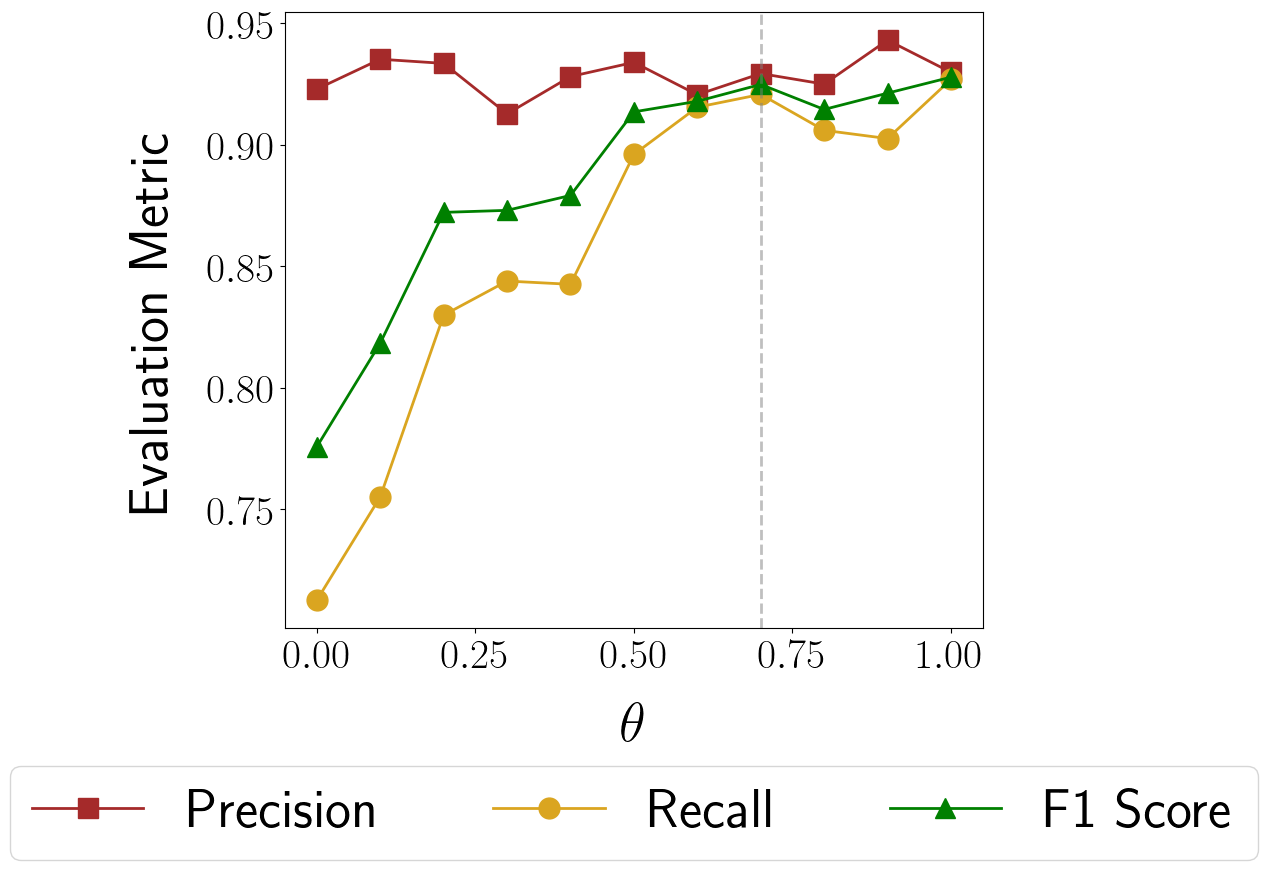

In [6]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = 0.1*np.arange(11)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = get_results_path('no_split', 3, 64, 5, np.round(theta,1), 50)
    # dir = os.path.dirname(os.path.dirname(dir))
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


print(precisions)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.savefig('../figures/no_split-theta_tuning.pdf', format="pdf", bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

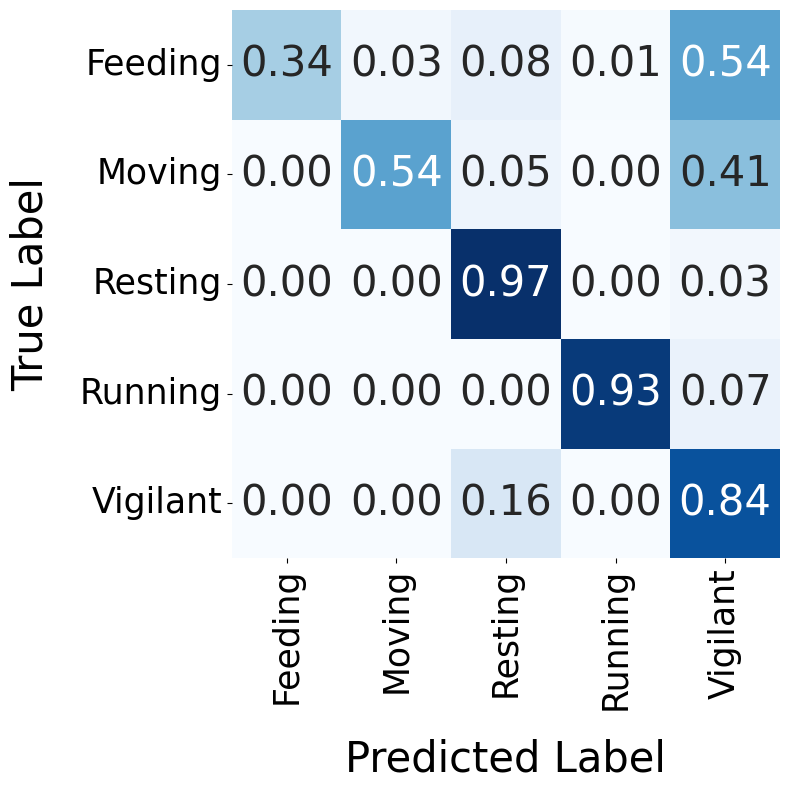

In [8]:
dir = get_results_path('no_split', 3, 64, 5, 0.0, 50)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path='../figures/no_split-confusion_mat_theta0.0.pdf')

<Figure size 640x480 with 0 Axes>

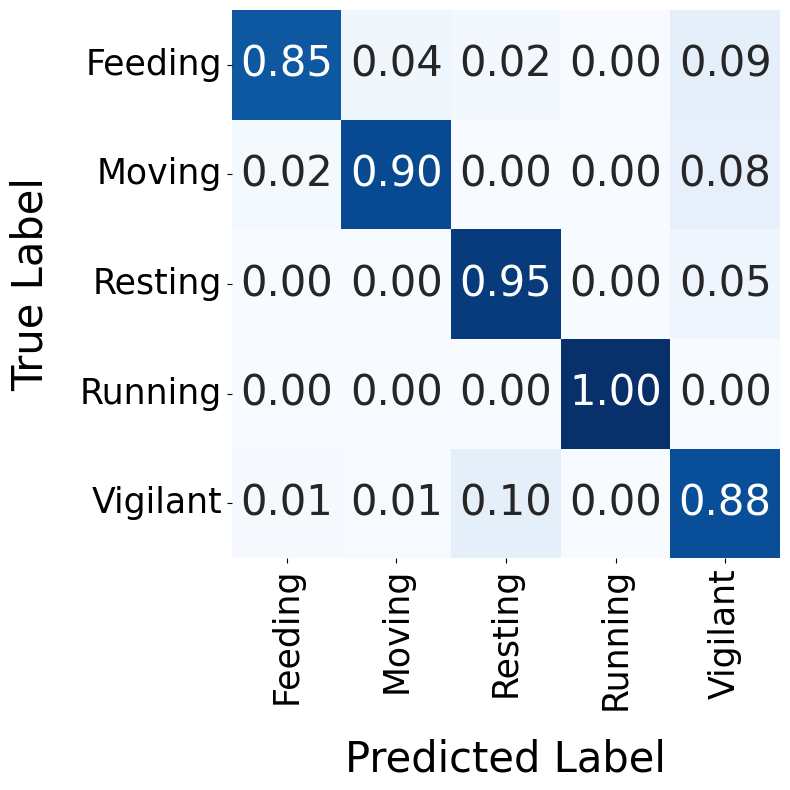

In [9]:
dir = get_results_path('no_split', 3, 64, 5, 0.7, 50)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path='../figures/no_split-confusion_mat_theta0.7.pdf')

In [10]:
print('VALIDATION PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average=None), 3)}))

print('VALIDATION RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'recall': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average=None), 3)}))

print('VALIDATION F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'f1 score': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average=None), 3)}))

print('VALIDATION ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

VALIDATION PRECISION SCORE
---------------------
Average precision: 0.929
   behavior  precision
0   Feeding      0.897
1   Resting      0.927
2    Moving      0.956
3   Running      1.000
4  Vigilant      0.867
VALIDATION RECALL SCORE
---------------------
Average recall: 0.921
   behavior  recall
0   Feeding   0.897
1   Resting   0.871
2    Moving   0.950
3   Running   1.000
4  Vigilant   0.886
VALIDATION F1 SCORE
---------------------
Average F1 score: 0.925
   behavior  f1 score
0   Feeding     0.897
1   Resting     0.898
2    Moving     0.953
3   Running     1.000
4  Vigilant     0.876
VALIDATION ACCURACY
---------------------
Accuracy: 0.929


In [11]:
print('TEST PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average=None), 3)}))

print('TEST RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'recall': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average=None), 3)}))

print('TEST F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'f1 score': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average=None), 3)}))

print('TEST ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

TEST PRECISION SCORE
---------------------
Average precision: 0.916
   behavior  precision
0   Feeding      0.832
1   Resting      0.940
2    Moving      0.955
3   Running      0.978
4  Vigilant      0.877
TEST RECALL SCORE
---------------------
Average recall: 0.918
   behavior  recall
0   Feeding   0.866
1   Resting   0.886
2    Moving   0.953
3   Running   1.000
4  Vigilant   0.884
TEST F1 SCORE
---------------------
Average F1 score: 0.917
   behavior  f1 score
0   Feeding     0.848
1   Resting     0.912
2    Moving     0.954
3   Running     0.989
4  Vigilant     0.881
TEST ACCURACY
---------------------
Accuracy: 0.93


#### Conformal Prediction

In [18]:
class Arguments:
        def __init__(self, experiment_name, 
                     batch_size, 
                     window_duration_percentile,
                     train_test_split,
                     train_val_split,
                     padding, 
                     theta,
                     filter_type,
                     cutoff_frequency,
                     cutoff_order,
                     normalization,
                     match,
                     min_duration):
                self.experiment_name = experiment_name
                self.batch_size = batch_size
                self.window_duration_percentile = window_duration_percentile
                self.train_test_split = train_test_split
                self.train_val_split = train_val_split
                self.padding = padding
                self.theta = theta
                self.filter_type = filter_type
                self.cutoff_frequency = cutoff_frequency
                self.cutoff_order = cutoff_order
                self.normalization = normalization
                self.match = match
                self.min_duration = min_duration


args = Arguments(experiment_name='no_split', 
                batch_size=64, 
                window_duration_percentile=50, 
                train_test_split=0.2, 
                train_val_split=0.2, 
                padding='repeat', 
                theta=0.8, 
                filter_type='high', 
                cutoff_frequency=0, 
                cutoff_order=5, 
                normalization=0,
                match=0,
                min_duration=1.0)

In [6]:
metadata = pd.read_csv(get_metadata_path()) # load metadata
all_annotations = combined_annotations(video_path=get_video_labels_path(),
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, label_encoder = setup_data_objects(metadata, 
                                                                                                    all_annotations, 
                                                                                                    COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    BEHAVIORS, 
                                                                                                    args, 
                                                                                                    reuse_behaviors=['Eating', 'Moving', 'Running'],
                                                                                                    acc_data_path=get_matched_data_path(), 
                                                                                                    acc_metadata_path=get_matched_metadata_path()) 
train_dataloader, val_dataloader, test_dataloader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)

Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 6311
Before overlap, 
no. of train observations: 6311, no. of test observations: 6311
Overlapping indices of shape = (6311,)
After removing overlaps, 
no. of train observations: 5048, no. of test observations: 1263

Matching annotations to acceleration snippets takes 69.722971 seconds


/home/medhaaga/AWD-Biologging/notebooks/../src/utils/data.py:318: UserWarning: train and test filters overlap
  warnings.warn("train and test filters overlap", UserWarning)


Creating fixed-duration windows takes 6.806006 seconds.

Time series duration window = 12.937


In [7]:
print(f'Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}')
print(X_train.shape, X_val.shape, X_test.shape)

print("Class distribution of train set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_train, return_counts=True)[1]}))
print("")

print("Class distribution of validation set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_val, return_counts=True)[1]}))
print("")

print("Class distribution of test set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_test, return_counts=True)[1]}))
print("")


Total: 6743
(4300, 3, 206) (1076, 3, 206) (1367, 3, 206)
Class distribution of train set
--------------------------------
   Behavior  Proportion
0   Feeding          98
1    Moving         462
2   Resting        1392
3   Running         113
4  Vigilant        2235

Class distribution of validation set
--------------------------------
   Behavior  Proportion
0   Feeding          24
1    Moving         116
2   Resting         349
3   Running          28
4  Vigilant         559

Class distribution of test set
--------------------------------
   Behavior  Proportion
0   Feeding          30
1    Moving         158
2   Resting         436
3   Running          44
4  Vigilant         699



In [11]:
from src.utils.simulations import energy_distance, compute_features
import ot
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_features = compute_features(X_train)
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = compute_features(X_test)
X_test_features = scaler.transform(X_test_features)

ot_value = np.round(ot.sliced_wasserstein_distance(X_train_features, X_test_features, n_projections=100), 4)
energy_value = np.round(energy_distance(X_train_features, X_test_features), 4)
print(f"{'Sliced Wasserstein distance:':<15} {ot_value} | {'Energy distance:':<15} {energy_value}")

Sliced Wasserstein distance: 0.1107 | Energy distance: 0.0094



The true behavior is Feeding and the RAPS is ['Moving' 'Vigilant' 'Feeding'] with scores [0.25100285 0.20664917 0.2045405 ]

The true behavior is Moving and the RAPS is ['Moving' 'Vigilant'] with scores [0.34932446 0.19765273]

The true behavior is Resting and the RAPS is ['Resting' 'Vigilant'] with scores [0.32884508 0.20312937]

The true behavior is Running and the RAPS is ['Running'] with scores [0.4038456]

The true behavior is Vigilant and the RAPS is ['Vigilant' 'Resting'] with scores [0.33906215 0.1897241 ]


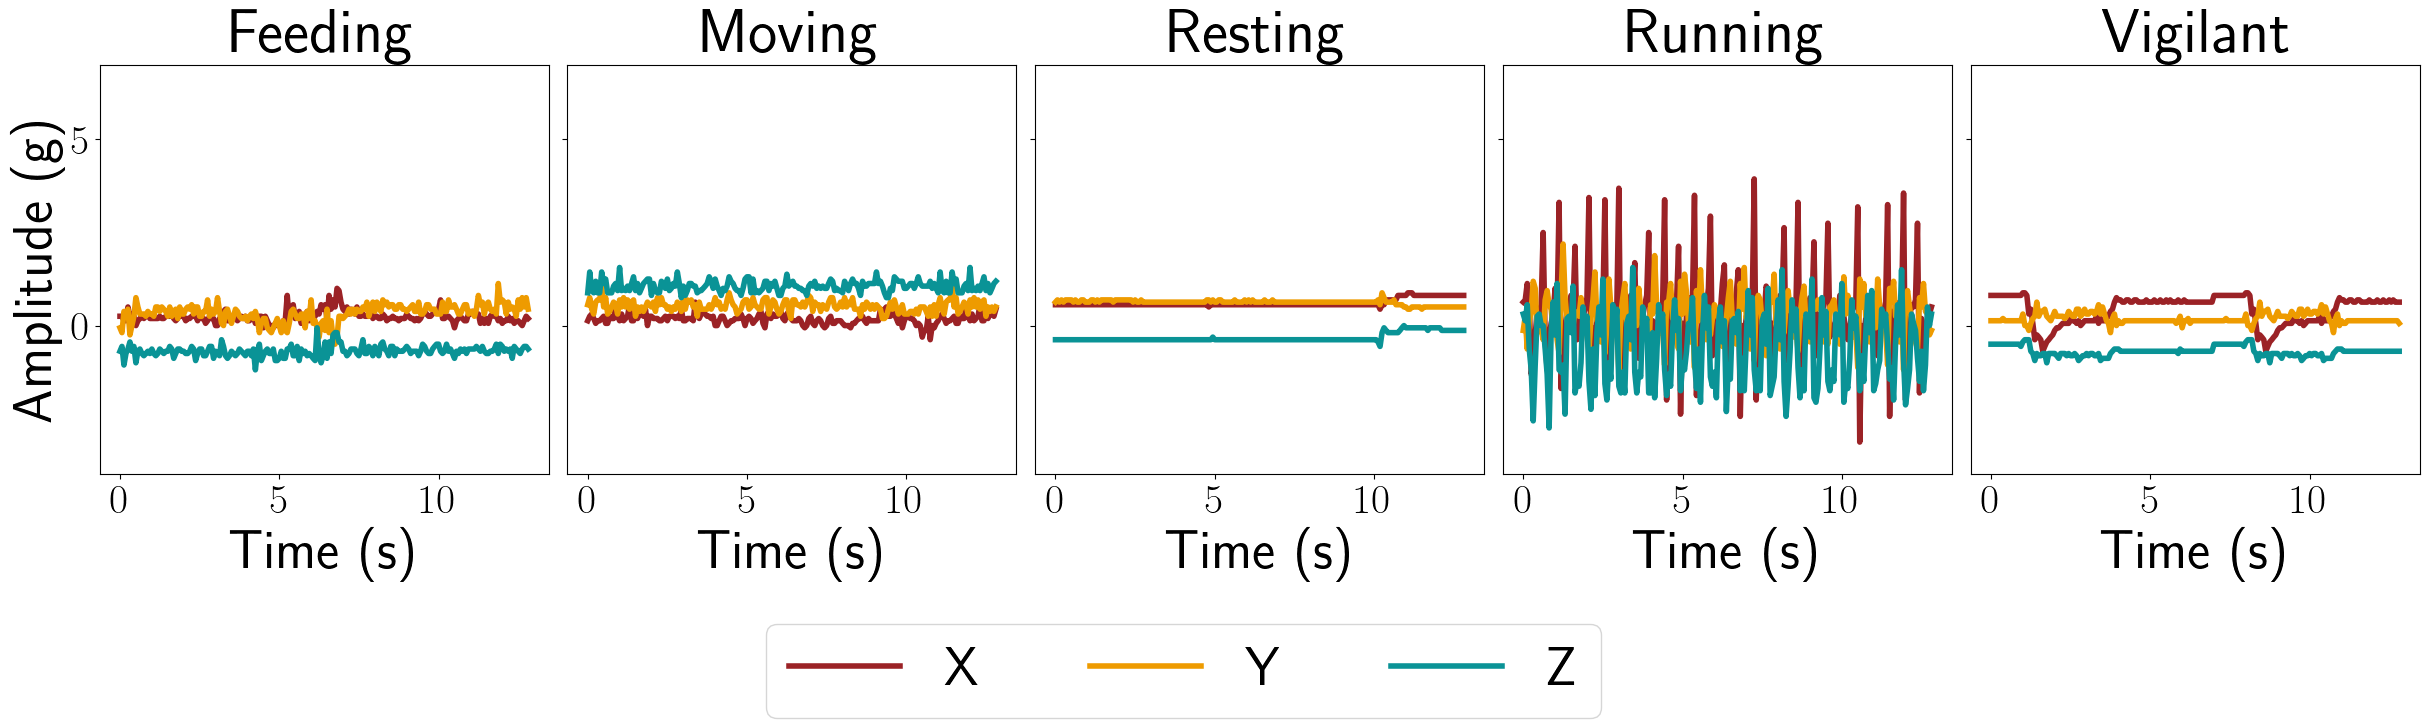

In [47]:
# For example: the prediction sets for a random sample of 10 observations is:
np.random.seed(seed=2)
from scipy.special import softmax
cmodel = torch.load(os.path.join(dir, 'cmodel.pt'), weights_only=False)
cmodel = cmodel.to(device)
idx = [np.random.choice(np.where(y_test == i)[0]) for i in range(len(BEHAVIORS)) ]
# colors = sns.color_palette('husl', 3)
colors =  ['#9b2226', '#ee9b00', '#0a9396']
fig, axs = plt.subplots(1, 5, figsize=(25, 6), sharey=True)

for n,i in enumerate(idx):
    with torch.no_grad():
        acc, target = torch.tensor(X_test[i], dtype=torch.float32), label_encoder.inverse_transform([y_test[i]])[0]
        logits, set = cmodel(acc.unsqueeze(0).to(device))
        logits_numpy = logits.detach().cpu().numpy()
        scores = softmax(logits_numpy, axis=1)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[0], color=colors[0], label='X', linewidth=4)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[1], color=colors[1], label='Y', linewidth=4)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[2], color=colors[2], label='Z', linewidth=4)
        axs[n].set_title(target)
        axs[n].set_ylim(-4, 7)
        axs[n].set_xlabel('Time (s)')
    print("")
    print(f'The true behavior is {target} and the RAPS is {label_encoder.inverse_transform(set[0])} with scores {scores[0][set[0]]}')
axs[0].set_ylabel('Amplitude (g)')
fig.tight_layout(pad=1.0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center',
        bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.savefig('../figures/no_split-RAPS.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
ctraindataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=args.batch_size, shuffle=False)
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=args.batch_size, shuffle=False)

# coverage of top1, top2, and RAPS predictive sets on train data
no_split_train_top1, no_split_train_topK, no_split_train_coverage, no_split_train_size = validate(ctraindataloader, cmodel, print_bool=True, topk=(1,2))

# coverage of top1, top2, and RAPS predictive sets on test data
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 4300 | Avg Time: 0.005 | Avg Cvg@1: 0.879 | Avg Cvg@K: 0.993 | Avg Cvg@RAPS: 0.951 | Avg Size@RAPS: 1.324

N: 1367 | Avg Time: 0.003 | Avg Cvg@1: 0.861 | Avg Cvg@K: 0.983 | Avg Cvg@RAPS: 0.936 | Avg Size@RAPS: 1.317

